## Семинар 6 "Segmentation"

ФИО: Усцов Артем Алексеевич

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 15 декабря 2022).  
Скорее всего будут дополнительные плюшки для призеров конкурса.


In [2]:
!pip install pytorch_lightning
!pip install imagecodecs-lite
!pip install --upgrade tifffile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 796 kB 31.9 MB/s 
     |████████████████████████████████| 529 kB 66.6 MB/s 
     |████████████████████████████████| 136 kB 62.5 MB/s 
     |████████████████████████████████| 87 kB 8.3 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=da2be5ca31de39803dac80abf9a2155109ff16382c632327c557c37a39c4a837
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.0 MB 88.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!wget https://www.dropbox.com/sh/z4hbbzqai0ilqht/AADp_8oefNFs2bjC2kzl2_Fqa/training.zip -P dataset/
!wget https://www.dropbox.com/sh/z4hbbzqai0ilqht/AABuUJQJ5yG5oCuziYzYu8jWa/test.zip -P dataset/

--2022-11-05 19:13:34--  https://www.dropbox.com/sh/z4hbbzqai0ilqht/AADp_8oefNFs2bjC2kzl2_Fqa/training.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/z4hbbzqai0ilqht/AADp_8oefNFs2bjC2kzl2_Fqa/training.zip [following]
--2022-11-05 19:13:35--  https://www.dropbox.com/sh/raw/z4hbbzqai0ilqht/AADp_8oefNFs2bjC2kzl2_Fqa/training.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbdb383cf4259028c0a8874ab12.dl.dropboxusercontent.com/cd/0/inline/BwPCwjphIn3Be9NXve-jvlMXuhLsyg7pbIN4yOFrrNZXJXzZwbWSKEZwHij7y6s1f7L_MdUW8WHAN3dBwrhRke9icZJyyaqViHN80KznAl3k1_5k0l3Iqs2cXPQ11Qglp-JcfQld6HYnOcGOcqzb35EdIltveCdi4rM375IR1AVE5A/file# [following]
--2022-11-05 19:13:35--  https://ucbdb383cf4259028c0a8874ab12.dl.dropboxusercontent.com/cd/0/inl

In [10]:
!unzip dataset/test.zip
!unzip dataset/training.zip && mv ./training ./train

Archive:  dataset/test.zip
   creating: test/
   creating: test/images/
  inflating: test/images/01_test.tif  
  inflating: test/images/02_test.tif  
  inflating: test/images/03_test.tif  
  inflating: test/images/04_test.tif  
  inflating: test/images/05_test.tif  
  inflating: test/images/06_test.tif  
  inflating: test/images/07_test.tif  
  inflating: test/images/08_test.tif  
  inflating: test/images/09_test.tif  
  inflating: test/images/10_test.tif  
  inflating: test/images/11_test.tif  
  inflating: test/images/12_test.tif  
  inflating: test/images/13_test.tif  
  inflating: test/images/14_test.tif  
  inflating: test/images/15_test.tif  
  inflating: test/images/16_test.tif  
  inflating: test/images/17_test.tif  
  inflating: test/images/18_test.tif  
  inflating: test/images/19_test.tif  
  inflating: test/images/20_test.tif  
   creating: test/mask/
 extracting: test/mask/01_test_mask.gif  
 extracting: test/mask/02_test_mask.gif  
 extracting: test/mask/03_test_mask.gif 

In [213]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms as tsf

from pathlib import Path
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import PIL
from PIL import Image

import skimage
from skimage import io
import skimage.transform
from imagecodecs import imread
import imageio


TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'

import matplotlib.pyplot as plt
%matplotlib inline

In [214]:
t.cuda.is_available()

True

In [3]:
!nvidia-smi

Sat Nov  5 21:07:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [215]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2] > 3:
            assert(img[:,:,3]!=255).sum() == 0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data

In [216]:
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/")

In [217]:
class Dataset():
    def __init__(
        self, data,
        source_transform,
        target_transform,
    ):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform

    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask

    def __len__(self):
        return len(self.datas)

In [218]:
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize(
        (128,128), 
        interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),
    ]
)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [219]:
train_dataset = Dataset(train_data, s_trans, t_trans)
train_loader = t.utils.data.DataLoader(
    train_dataset, 
    num_workers=1, 
    batch_size=32,
    shuffle=True,
    pin_memory=True,
)

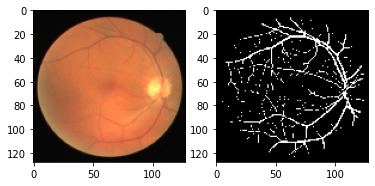

In [220]:
img, mask = train_dataset[12]

plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)

plt.subplot(122)
plt.imshow(mask[0].numpy(), cmap="gray")

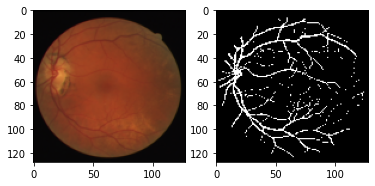

In [221]:
img, mask = train_dataset[5]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)

plt.subplot(122)
plt.imshow(mask[0].numpy(), cmap="gray")

In [222]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [278]:
class UNet(nn.Module):
    def __init__(self, n_channels):
        super(UNet, self).__init__()
        self.inc = double_conv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = nn.Conv2d(64, n_channels, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.sigmoid(x)
        return x

In [279]:
class SoftDiceLoss(nn.Module):
    '''
    soft-dice loss, useful in binary segmentation
    '''
    def __init__(self,
                 p=1,
                 smooth=1):
        super(SoftDiceLoss, self).__init__()
        self.p = p
        self.smooth = smooth

    def forward(self, probs, labels):
        '''
        inputs:
            logits: tensor of shape (N, H, W, ...)
            label: tensor of shape(N, H, W, ...)
        output:
            loss: tensor of shape(1, )
        '''
        numer = (probs * labels).sum()
        denor = (probs.pow(self.p) + labels.pow(self.p)).sum()
        loss = 1. - (2 * numer + self.smooth) / (denor + self.smooth)
        return loss


In [280]:
from torch.autograd import Variable
from IPython.display import clear_output

In [341]:
def run_net_learning_process(net, optimizer, train_loader, 
                             epochs, criterion,
                             plot=True, verbose=True,
                             threshold=0.5,
                            ):

    train_loss_epochs = []
    train_accuracy_epochs = []

    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            accuracy = 0
            for batch_idx, (data, target) in enumerate(train_loader):
                data = data.cuda()
                target = target.cuda()
                data, target = Variable(data), Variable(target)

                optimizer.zero_grad()
                net_out = net(data)
                loss = criterion(net_out, target)
                losses.append(loss.data.item())

                accuracy = ((net_out > threshold) == target).float().mean()
                loss.backward()

                optimizer.step()

            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(accuracy.cpu())

            # для динамического обновления графиков, wait - очищает вывод
            clear_output(wait=True) 

            # детализация выводимой информации
            if verbose: 
                print(
                      f'Network: <{type(net).__name__}>\n'
                      f'Optimizer: <{type(optimizer).__name__}>\n'
                      f'Loss type: <{type(criterion).__name__}>\n\n'
                      f'Epoch: {epoch+1}\n'
                      f'<Train/Test>\n'
                      f'Loss: {train_loss_epochs[-1]:0.3f} '
                      f'| Accuracy: {train_accuracy_epochs[-1]:0.3f}'
                     )

            if plot:
                plt.figure(figsize=(12, 5))

                # Отображение изменения ошибки
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')

                # Отображение изменения accuracy
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt as KI:
        print(KI)

    return train_loss_epochs, \
       train_accuracy_epochs

In [342]:
img.shape

torch.Size([3, 128, 128])

In [343]:
mask.shape

torch.Size([1, 128, 128])

In [344]:
model = UNet(3).cuda()
criterion = SoftDiceLoss().cuda()

optimizer = t.optim.RMSprop(
    model.parameters(), 
    lr=1e-4, 
    momentum=0.9, 
    weight_decay=1e-4,
)

Network: <UNet>
Optimizer: <RMSprop>
Loss type: <SoftDiceLoss>

Epoch: 200
<Train/Test>
Loss: 0.136 | Accuracy: 0.979


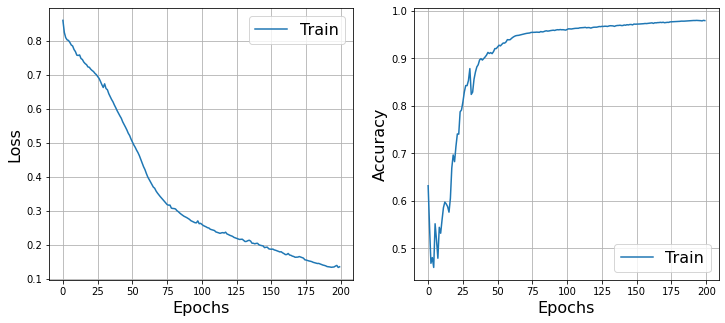

100%|██████████| 200/200 [02:36<00:00,  1.28it/s]


In [345]:
tr, tr_ac =\
run_net_learning_process(
    net=model, 
    optimizer=optimizer, 
    epochs=200, 
    criterion=criterion,
    train_loader=train_loader, 
    plot=True, 
    verbose=True,
    threshold=0.5,
)

По наблюдениям, 200 итераций более, чем достаточно, чтобы выйти на линию "насыщения" на трейне

In [346]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform

    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img

    def __len__(self):
        return len(self.datas)

In [347]:
testset = TestDataset(TEST_PATH, s_trans)
test_dataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [348]:
if not os.path.isdir("result"):
  os.makedirs("result")

In [349]:
model = model.eval()
for ex_id, data in enumerate(test_dataloader):
    data = t.autograd.Variable(data, volatile=True).cuda()
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)

    imageio.imwrite("result/%s.png" % (ex_id + 1), tm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


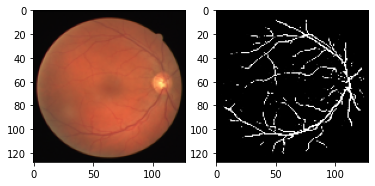

In [350]:
tm = o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm, cmap="gray")

В целом, выглядит очень реалистично

In [339]:
!zip -r result.zip result

  adding: result/ (stored 0%)
  adding: result/8.png (deflated 1%)
  adding: result/12.png (deflated 1%)
  adding: result/16.png (deflated 1%)
  adding: result/1.png (deflated 1%)
  adding: result/20.png (deflated 1%)
  adding: result/9.png (deflated 1%)
  adding: result/3.png (deflated 1%)
  adding: result/17.png (deflated 1%)
  adding: result/10.png (deflated 1%)
  adding: result/11.png (deflated 1%)
  adding: result/13.png (deflated 1%)
  adding: result/7.png (deflated 1%)
  adding: result/2.png (deflated 1%)
  adding: result/4.png (deflated 1%)
  adding: result/6.png (deflated 1%)
  adding: result/18.png (deflated 1%)
  adding: result/14.png (deflated 1%)
  adding: result/19.png (deflated 1%)
  adding: result/5.png (deflated 1%)
  adding: result/15.png (deflated 1%)


Добавим аугментации. 

Возьмем небольшие углы поворота и растяжения картинки, чтобы не сломать модель

In [375]:
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.RandomAffine(0.1, (0.1, 0.1)),
    tsf.Lambda(lambda x : x + t.normal(0, 0.001, size=tuple(x.data.shape))),
    tsf.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize(
        (128,128), 
        interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),
    ]
)

In [376]:
train_dataset = Dataset(train_data, s_trans, t_trans)
train_loader = t.utils.data.DataLoader(
    train_dataset, 
    num_workers=1, 
    batch_size=32,
    shuffle=True,
    pin_memory=True,
)

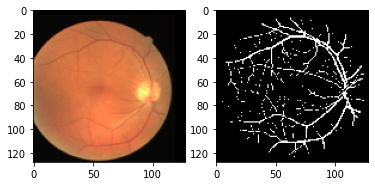

In [377]:
img, mask = train_dataset[12]

plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)

plt.subplot(122)
plt.imshow(mask[0].numpy(), cmap="gray")

In [378]:
model_1 = UNet(3).cuda()
criterion = SoftDiceLoss().cuda()

optimizer = t.optim.RMSprop(
    model_1.parameters(), 
    lr=1e-4, 
    momentum=0.9, 
    weight_decay=1e-4,
)

Network: <UNet>
Optimizer: <RMSprop>
Loss type: <SoftDiceLoss>

Epoch: 200
<Train/Test>
Loss: 0.683 | Accuracy: 0.834


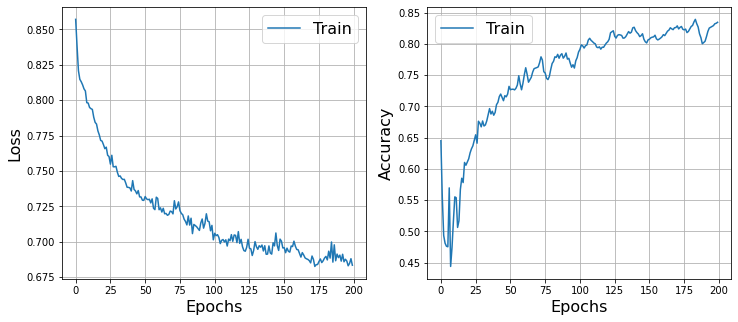

100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


In [379]:
tr_aug, tr_ac_aug =\
run_net_learning_process(
    net=model_1, 
    optimizer=optimizer, 
    epochs=200, 
    criterion=criterion,
    train_loader=train_loader, 
    plot=True, 
    verbose=True,
    threshold=0.5,
)

Модели стало заметно тяжелее обучаться, ошибка сильно возросла

Принято решение увеличить количество эпох до 400

In [382]:
model_1 = UNet(3).cuda()
criterion = SoftDiceLoss().cuda()

optimizer = t.optim.RMSprop(
    model_1.parameters(), 
    lr=1e-4, 
    momentum=0.9, 
    weight_decay=1e-4,
)

Network: <UNet>
Optimizer: <RMSprop>
Loss type: <SoftDiceLoss>

Epoch: 400
<Train/Test>
Loss: 0.680 | Accuracy: 0.837


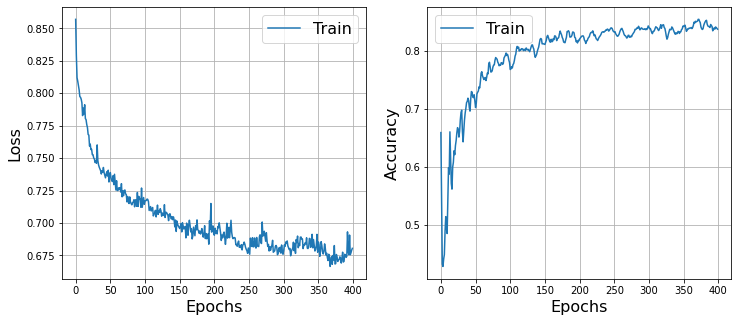

100%|██████████| 400/400 [05:12<00:00,  1.28it/s]


In [383]:
tr_aug, tr_ac_aug =\
run_net_learning_process(
    net=model_1, 
    optimizer=optimizer, 
    epochs=400, 
    criterion=criterion,
    train_loader=train_loader, 
    plot=True, 
    verbose=True,
    threshold=0.5,
)

In [384]:
if not os.path.isdir("result_aug"):
  os.makedirs("result_aug")

In [385]:
model_1 = model_1.eval()
for ex_id, data in enumerate(test_dataloader):
    data = t.autograd.Variable(data, volatile=True).cuda()
    o = model_1(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)

    imageio.imwrite("result_aug/%s.png" % (ex_id + 1), tm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


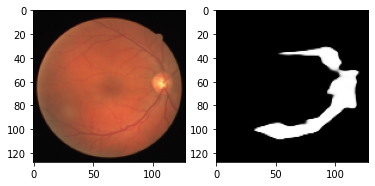

In [386]:
tm = o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm, cmap="gray")

Внесение аугментаций сильно ухудшило качество)
Как итог, пока лучшая модель - обученная впервые

Если будет время - поиграться с лоссом, оптимизаторами, возможно посмотреть другие аугментации, поиграться со слоями, в частности с функцией активации

В качестве результатов использовать папку __results__

In [387]:
!zip -r result_aug.zip result_aug

  adding: result_aug/ (stored 0%)
  adding: result_aug/8.png (deflated 12%)
  adding: result_aug/12.png (deflated 6%)
  adding: result_aug/16.png (deflated 9%)
  adding: result_aug/1.png (deflated 7%)
  adding: result_aug/20.png (deflated 9%)
  adding: result_aug/9.png (deflated 11%)
  adding: result_aug/3.png (deflated 35%)
  adding: result_aug/17.png (deflated 6%)
  adding: result_aug/10.png (deflated 6%)
  adding: result_aug/11.png (deflated 9%)
  adding: result_aug/13.png (deflated 8%)
  adding: result_aug/7.png (deflated 6%)
  adding: result_aug/2.png (deflated 8%)
  adding: result_aug/4.png (deflated 6%)
  adding: result_aug/6.png (deflated 9%)
  adding: result_aug/18.png (deflated 8%)
  adding: result_aug/14.png (deflated 7%)
  adding: result_aug/19.png (deflated 6%)
  adding: result_aug/5.png (deflated 7%)
  adding: result_aug/15.png (deflated 4%)
